# Airline Passenger Satisfaction Forecasting

## Disclaimer

**If you opened this project from my CV, you are already viewing this notebook via nbviewer, so you can skip this disclaimer**.

This Jupyter notebook contains interactive plotly charts. Github performs a static render of the notebooks and it doesn't include the embedded HTML/JavaScript that makes up a plotly chart. Jupyter Notebook files with a .ipynb extension will render as static HTML files on GitHub. It means that interactive features of the notebook, such as interactive plotly plots, will not work. To view this Jupyter notebook with JavaScript content rendered you can use nbviewer: https://nbviewer.org. **To open this Jupyter Notebook in nbviewer, please, paste this link https://github.com/MaxTeselkin/Airline-Passenger-Satisfaction-Forecasting/blob/main/Airline_Passenger_Satisfaction.ipynb into nbviewer and everythink will be displayed correctly.**


## Data Description

This dataset is dedicated to passenger satisfaction survey and contains the following columns:

**id**: Customer ID

**Gender**: Gender of the passengers (Female, Male)

**Customer Type**: The customer type (Loyal customer, disloyal customer)

**Age**: The actual age of the passengers

**Type of Travel**: Purpose of the flight of the passengers (Personal Travel, Business Travel)

**Class**: Travel class in the plane of the passengers (Business, Eco, Eco Plus)

**Flight distance**: The flight distance of this journey

**Inflight wifi service**: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)

**Departure/Arrival time convenient**: Satisfaction level of Departure/Arrival time convenient

**Ease of Online booking**: Satisfaction level of online booking

**Gate location**: Satisfaction level of Gate location

**Food and drink**: Satisfaction level of Food and drink

**Online boarding**: Satisfaction level of online boarding

**Seat comfort**: Satisfaction level of Seat comfort

**Inflight entertainment**: Satisfaction level of inflight entertainment

**On-board service**: Satisfaction level of On-board service

**Leg room service**: Satisfaction level of Leg room service

**Baggage handling**: Satisfaction level of baggage handling

**Check-in service**: Satisfaction level of Check-in service

**Inflight service**: Satisfaction level of inflight service

**Cleanliness**: Satisfaction level of Cleanliness

**Departure Delay in Minutes**: Minutes delayed when departure

**Arrival Delay in Minutes**: Minutes delayed when Arrival

**Satisfaction**: Airline satisfaction level (Satisfaction, neutral or dissatisfaction)

    
**P.S.** If you have downloaded this notebook and view it via your computer, please make sure that this notebook is marked as "trusted" (if it's not marked as such, just click on button in the upper right corner). It is necessary because plotly charts will be displayed only if notebook is marked as "trusted" (otherwise they will be displayed as blank spaces).

## Importing necessary libraries & loading data

In [1]:
! pip install catboost==1.1.1 --quiet

In [2]:
! pip install optuna==3.0.0 --quiet

In [3]:
! pip install plotly==5.11.0 --quiet

In [4]:
! pip install shap --quiet

In [1]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
import optuna
from optuna.integration import CatBoostPruningCallback
from optuna.samplers import TPESampler
from sklearn.metrics import (accuracy_score,
                             auc,
                             precision_score,
                             recall_score,
                             f1_score,
                             RocCurveDisplay)
from sklearn.model_selection import StratifiedKFold
import shap

In [2]:
# disabling warnings
warnings.filterwarnings('ignore')

In [48]:
# loading data
train_df = pd.read_csv('../input/airline-passenger-satisfaction/train.csv',
                       index_col='Unnamed: 0')
train_df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103904 entries, 0 to 103903
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103904 non-null  int64  
 1   Gender                             103904 non-null  object 
 2   Customer Type                      103904 non-null  object 
 3   Age                                103904 non-null  int64  
 4   Type of Travel                     103904 non-null  object 
 5   Class                              103904 non-null  object 
 6   Flight Distance                    103904 non-null  int64  
 7   Inflight wifi service              103904 non-null  int64  
 8   Departure/Arrival time convenient  103904 non-null  int64  
 9   Ease of Online booking             103904 non-null  int64  
 10  Gate location                      103904 non-null  int64  
 11  Food and drink                     1039

## Exploratory Data Analysis

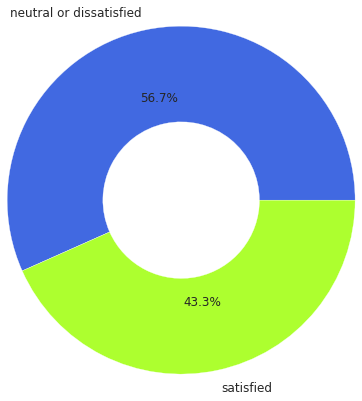

In [9]:
# checking for class imbalance
counts = train_df['satisfaction'].value_counts().values
labels = ['neutral or dissatisfied', 'satisfied']

plt.figure(figsize=(4, 4))
pie_plot, _, _ = plt.pie(counts,
                         radius=2.0,
                         labels=labels,
                         colors = ['royalblue', 'greenyellow'],
                         autopct='%.1f%%',
                         textprops = {'fontsize': 12})
plt.setp(pie_plot, width=1.1, edgecolor='white')
plt.show()

57% of customers in the dataset are neutral or dissatisfied, 43% are satisfied. There is no serious class imbalance.

In [10]:
sns.set(rc={'figure.figsize': (10, 6)})

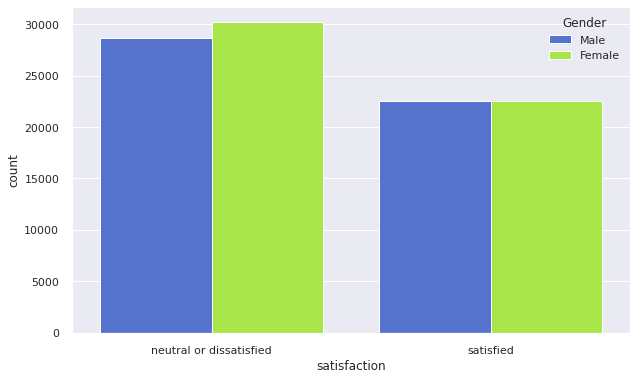

In [11]:
sns.countplot(x='satisfaction', hue='Gender', data=train_df, palette=['royalblue', 'greenyellow']);

According to the plot above, there is no significant difference by gender between satisfied and dissatisfied customers, the proportions are almost equal.

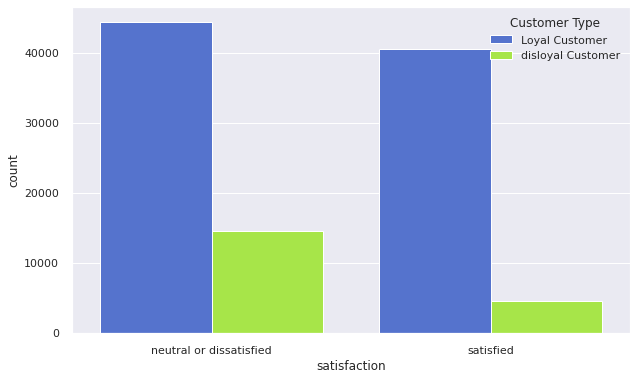

In [12]:
sns.countplot(x='satisfaction',
              hue='Customer Type',
              data=train_df,
              palette=['royalblue', 'greenyellow']);

It is interesting that loyal customers are neutral or dissatisfied more often than disloyal. It can be caused by class imbalance (perhaps there are significantly more loyal customers than disloyal). Let's check this hypothesis and find out, how many % of airline's customers are loyal.

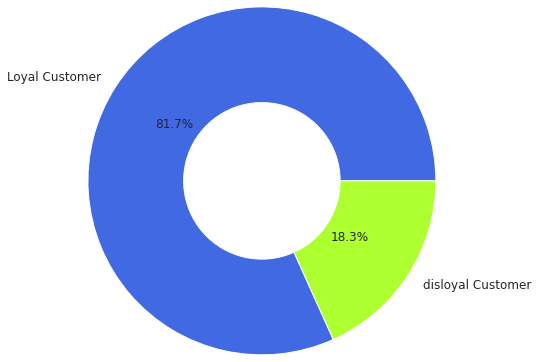

In [13]:
counts = train_df['Customer Type'].value_counts().values
labels = ['Loyal Customer', 'disloyal Customer']

plt.figure(figsize=(4, 4))
pie_plot, _, _ = plt.pie(counts,
                         radius=2.0,
                         labels=labels,
                         colors = ['royalblue', 'greenyellow'],
                         autopct='%.1f%%',
                         textprops = {'fontsize': 12})
plt.setp(pie_plot, width=1.1, edgecolor='white')
plt.show()

81,7% of customers are loyal, this is the reason for the fact that both satisfied and dissatisfied customers are primarily loyal.

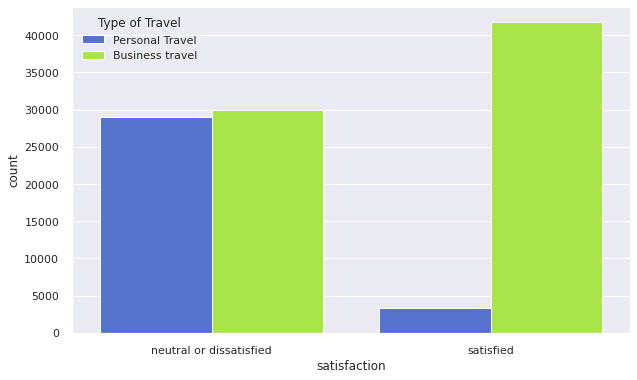

In [14]:
sns.countplot(x='satisfaction',
              hue='Type of Travel',
              data=train_df,
              palette=['royalblue', 'greenyellow']);

The amount of personal travels and business tarvels among neutral or dissatisfied customers is almost equal, while most of satisfied customers use business travels.

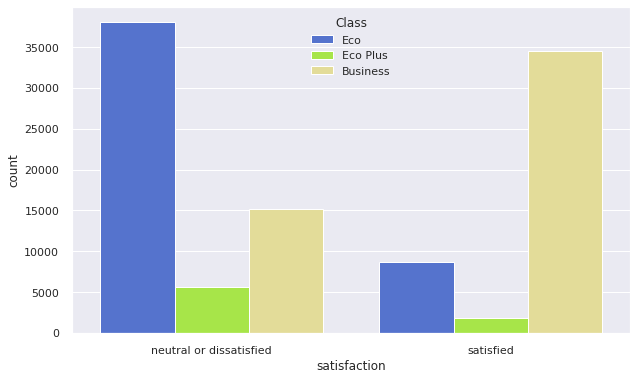

In [15]:
sns.countplot(x='satisfaction',
              hue='Class',
              hue_order=['Eco', 'Eco Plus', 'Business'],
              data=train_df,
              palette=['royalblue', 'greenyellow', 'khaki']);

Most of neutral or dissatisfied customers travel eco class, while most of satisfied customers travel business class (and it perfectly corresponds to the fact that most of satisfied customers use business travels, which was already found out from the penultimate plot).

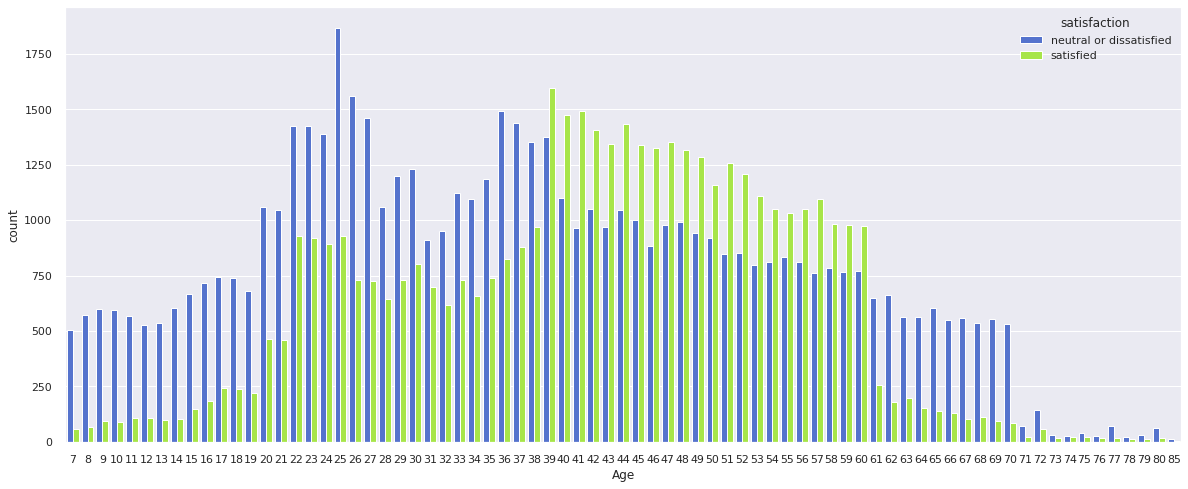

In [16]:
plt.figure(figsize=(20, 8))
sns.countplot(x='Age', hue='satisfaction', data=train_df, palette=['royalblue', 'greenyellow']);

The plot shows that customers whose age is between 39 and 60 are the most satisfied, while most of neutral or dissatisfied customers are young people and kids.

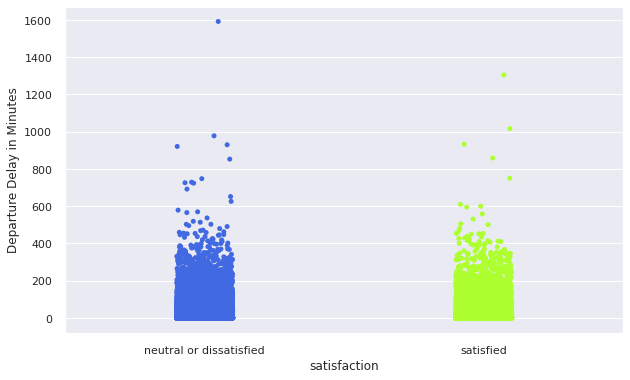

In [17]:
sns.stripplot(x='satisfaction',
              y='Departure Delay in Minutes',
              data=train_df,
              palette=['royalblue', 'greenyellow']);

It can be concluded that neutral or dissatisfied customers usually have a little bit longer departure delays, but at the same time there are a lot of both satisfied and dissatisfied customers who had 0-400 minute departure delay, so this factor is probably not crucial for customer's satisfaction.

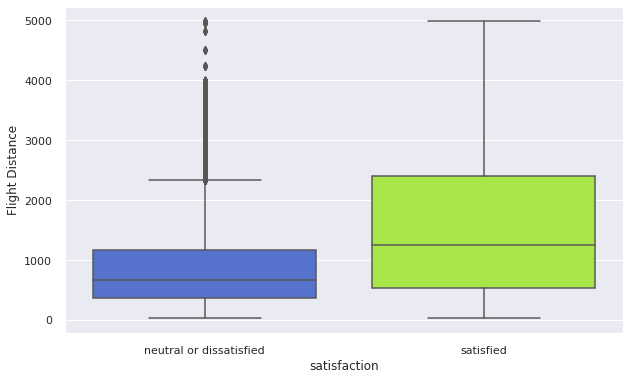

In [18]:
sns.boxplot(x='satisfaction',
            y='Flight Distance',
            data=train_df,
            palette=['royalblue', 'greenyellow']);

The box plots show that satisified customers usually travel longer distances than neutral or dissatisfied.

In [19]:
# creating dataframe with mean satisfaction scores
lower = train_df.columns.to_list().index('Inflight wifi service')
upper = train_df.columns.to_list().index('Cleanliness') + 1
satisfaction_indexes = train_df.columns.to_list()[lower:upper]
satisfaction_indexes.append('satisfaction')
satisfaction_scores = train_df[satisfaction_indexes].groupby('satisfaction').mean()

# buliding radar plot
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=satisfaction_scores.loc['neutral or dissatisfied'].values,
    theta=satisfaction_scores.columns.to_list(),
    line=go.scatterpolar.Line(color='royalblue'),
    name='neutral or dissatisfied'))

fig.add_trace(go.Scatterpolar(
    r=satisfaction_scores.loc['satisfied'].values,
    theta=satisfaction_scores.columns.to_list(),
    line=go.scatterpolar.Line(color='greenyellow'),
    name='satisfied'))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 5]
    )),
  showlegend=True
)

fig.show()

The radar plot above shows that satisfied customers usually have higher satisfaction levels of airline services, what is logical. However, when it comes to gate location and departure/arrival time convenient, satisfaction levels are almost equal, so these features probably do not affect customers' satisfaction a lot.

## Data Preprocessing

CatBoost can handle both missing values and categorical features. CatBoost uses smart variant of categorical feature encoding, which works better than traditional encoding, but method of handling missing values is not so smart - CatBoost simply replaces missing values with maximum or minimum values, and this is not the best method of handling missing values. It is better use KNNImputer to impute missing values. So I will encode categorical variables, impute missing values with KNNImputer and decode categorical variables back to use CatBoost variant of encoding later.

In [4]:
# choosing categorial features
categorical_features = [col for col in train_df.columns if train_df[col].dtype == 'object' and col != 'satisfaction']
categorical_features

['Gender', 'Customer Type', 'Type of Travel', 'Class']

In [5]:
# function for categorical features encoding
def encode_cat_features(df):
    df['Gender'] = df['Gender'].apply(lambda x: 1 if x=='Male' else 0)
    df['Customer Type'] = df['Customer Type'].apply(lambda x: 1 if x=='Loyal Customer' else 0)
    df['Type of Travel'] = df['Type of Travel'].apply(lambda x: 1 if x=='Personal Travel' else 0)
    df['Class'] = df['Class'].replace({'Eco': 0, 'Eco Plus': 1, 'Business': 2})

In [6]:
# function for categorical features decoding
def decode_cat_features(df):
    df['Gender'] = df['Gender'].replace({0: 'Female', 1: 'Male'})
    df['Customer Type'] = df['Customer Type'].replace({0: 'disloyal Customer', 1: 'Loyal Customer'})
    df['Type of Travel'] = df['Type of Travel'].replace({0: 'Business travel', 1: 'Personal Travel'})
    df['Class'] = df['Class'].replace({0: 'Eco', 1: 'Eco Plus', 2: 'Business'})

In [7]:
# function for data preprocessing
def preprocess_data(df, mode='training'):
    df.drop('id', axis=1, inplace=True)
    df['satisfaction'] = df['satisfaction'].apply(lambda x: 1 if x=='satisfied' else 0)
    encode_cat_features(df)
    if mode == 'training':
        imputer = KNNImputer(n_neighbors=5)
        df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
        decode_cat_features(df)
        return df, imputer
    elif mode == 'inference':
        global fitted_imputer
        df = pd.DataFrame(fitted_imputer.transform(df), columns=df.columns)
        decode_cat_features(df)
        data = df.drop('satisfaction', axis=1)
        labels = df['satisfaction']
        return data, labels

In [8]:
train_df, fitted_imputer = preprocess_data(train_df, mode='training')

## Hyperparameter Tuning & Model Validation

In [9]:
# splitting the data into train and validation sets
data = train_df.drop('satisfaction', axis=1)
labels = train_df['satisfaction']
train_data, valid_data, train_labels, valid_labels = train_test_split(data,
                                                                      labels,
                                                                      test_size=0.25,
                                                                      shuffle=True)

In [26]:
def objective(trial):
    params = {'objective': 'MultiClass',
              'task_type': 'GPU',
              'eval_metric': 'TotalF1',
              'logging_level': 'Silent',
              'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
              'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1.0),
              'bootstrap_type': 'Bayesian',
              'depth': trial.suggest_int('depth', 3, 12),
              'boosting_type': 'Plain'}
    
    model = CatBoostClassifier(**params)
    model.fit(train_data,
              train_labels,
              cat_features=categorical_features,
              eval_set=[(valid_data, valid_labels)],
              early_stopping_rounds=5)
    preds = model.predict(valid_data)
    score = f1_score(valid_labels, preds)
    return score

In [27]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2022-11-21 20:44:08,668] A new study created in memory with name: no-name-2404b224-01a9-46fd-bbe9-8c2a8b552f60


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2022-11-21 20:45:32,250] Trial 0 finished with value: 0.8449629795826789 and parameters: {'n_estimators': 770, 'learning_rate': 0.0013470668180316273, 'l2_leaf_reg': 0.5372403056878294, 'depth': 3}. Best is trial 0 with value: 0.8449629795826789.
[I 2022-11-21 20:45:33,199] Trial 1 finished with value: 0.8449629795826789 and parameters: {'n_estimators': 749, 'learning_rate': 0.034982403535502485, 'l2_leaf_reg': 0.4566498699172784, 'depth': 3}. Best is trial 0 with value: 0.8449629795826789.
[I 2022-11-21 20:45:34,127] Trial 2 finished with value: 0.8918084824971342 and parameters: {'n_estimators': 865, 'learning_rate': 0.0022666432853446117, 'l2_leaf_reg': 0.2471724603038916, 'depth': 6}. Best is trial 2 with value: 0.8918084824971342.
[I 2022-11-21 20:45:35,430] Trial 3 finished with value: 0.9265015452143146 and parameters: {'n_estimators': 976, 'learning_rate': 0.012892554883063338, 'l2_leaf_reg': 0.004889007827625651, 'depth': 11}. Best is trial 3 with value: 0.9265015452143146.

In [28]:
trial= study.best_trial
print('Best hyperparameters: {}'.format(trial.params))

Best hyperparameters: {'n_estimators': 505, 'learning_rate': 0.0987969586860826, 'l2_leaf_reg': 0.006673856487751047, 'depth': 9}


In [29]:
print('Best F1-score: {}'.format(study.best_value))

Best F1-score: 0.955507714388231


In [30]:
best_params = trial.params

In [42]:
# function for model performance evaluation 
def evaluate_model(cv_model): 
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
     
    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []} 
 
    tprs = [] 
    aucs = [] 
    mean_fpr = np.linspace(0, 1, 100) 
    # plotting ROC-curve 
    fig, ax = plt.subplots(figsize=(10, 6)) 
    for i, (train_index, test_index) in enumerate(skf.split(data, labels)): 
        x_train, x_test, y_train, y_test = (data.iloc[train_index],
                                            data.iloc[test_index],
                                            labels.iloc[train_index],
                                            labels.iloc[test_index])
        cv_model.fit(x_train, y_train, cat_features=categorical_features, verbose=0) 
        y_pred = cv_model.predict(x_test) 
 
        metrics['accuracy'].append(accuracy_score(y_test, y_pred)) 
        metrics['precision'].append(precision_score(y_test, y_pred)) 
        metrics['recall'].append(recall_score(y_test, y_pred)) 
        metrics['f1_score'].append(f1_score(y_test, y_pred)) 
        viz = RocCurveDisplay.from_estimator(cv_model, 
                                             x_test, 
                                             y_test, 
                                             name='Fold {}'.format(i), 
                                             alpha=0.3, 
                                             lw=1.5, 
                                             ax=ax) 
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr) 
        interp_tpr[0] = 0.0 
        tprs.append(interp_tpr) 
        aucs.append(viz.roc_auc) 
 
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=0.8) 
 
    mean_tpr = np.mean(tprs, axis=0) 
    mean_tpr[-1] = 1.0 
    mean_auc = auc(mean_fpr, mean_tpr) 
    ax.plot(mean_fpr, 
            mean_tpr, 
            color='b', 
            label=r'Mean ROC (AUC = %0.2f)' % mean_auc, 
            lw=2, 
            alpha=0.8) 
 
    ax.set(xlim=[-0.05, 1.05], 
           ylim=[-0.05, 1.05], 
           title='ROC-curve') 
    ax.legend(loc='lower right') 
    plt.show() 
    # performance metrics 
    print('Accuracy score: {}'.format(np.mean(metrics['accuracy']))) 
    print('Precision score: {}'.format(np.mean(metrics['precision']))) 
    print('Recall score: {}'.format(np.mean(metrics['recall']))) 
    print('F1 score: {}'.format(np.mean(metrics['f1_score'])))

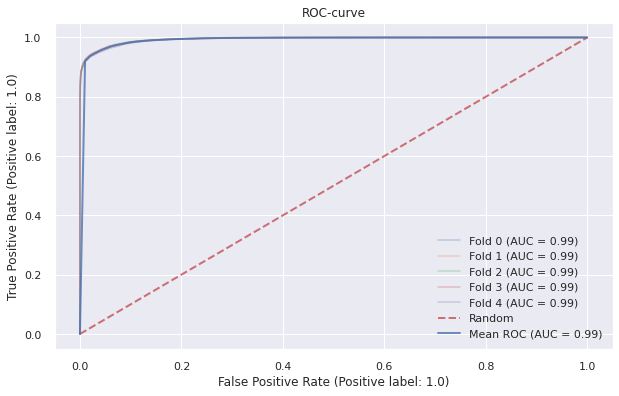

Accuracy score: 0.9611853052635304
Precision score: 0.9687176980948724
Recall score: 0.9408106607440312
F1 score: 0.9545597069667047


In [43]:
cv_model = CatBoostClassifier(**best_params, task_type='GPU')
evaluate_model(cv_model)

It can be concluded that model performed quite well and can be used for inference

## Inference

In [50]:
# loading test dataset
test_df = pd.read_csv('../input/airline-passenger-satisfaction/test.csv',
                       index_col='Unnamed: 0')
test_df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [51]:
# preprocessing test dataset
test_data, test_labels = preprocess_data(test_df, mode='inference')

In [10]:
best_params = {'n_estimators': 505, 'learning_rate': 0.0987969586860826, 'l2_leaf_reg': 0.006673856487751047, 'depth': 9}

In [11]:
# model training
model = CatBoostClassifier(**best_params, task_type='GPU')
model.fit(data, labels, cat_features=categorical_features, verbose=0, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [53]:
# model performance evaluation on unseen data
pred_labels = model.predict(test_data)

print('Accuracy score: {}'.format(accuracy_score(test_labels, pred_labels)))
print('Precision score: {}'.format(precision_score(test_labels, pred_labels)))
print('Recall score: {}'.format(recall_score(test_labels, pred_labels)))
print('F1 score: {}'.format(accuracy_score(test_labels, pred_labels)))

Accuracy score: 0.9625423467816446
Precision score: 0.969735182849937
Recall score: 0.9441375076734193
F1 score: 0.9625423467816446


In [55]:
# saving model to a binary file
model.save_model('catboost_airline')

## Model Interpretation

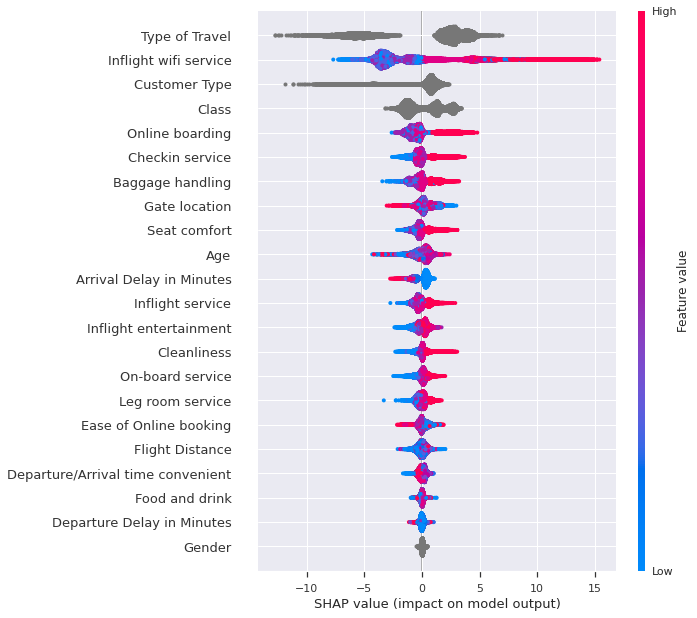

In [56]:
# calculating shap values for model interpretation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_data)
shap_object = explainer(test_data)
shap.plots.beeswarm(shap_object, max_display=22)



SHAP values show impact of each feature on model output. In comparison to permutation importance, SHAP values show not only feature importance, but also what is driving it. Color shows whether that feature was high or low for that row of the dataset. Horizontal location shows whether the effect of that value increased or decreased prediction.

Beeswarm plot shows that the most important features are type of travel, inflight wifi service and customer type.

Features, which have clear separation with wide spread (like type of travel) are very informative for classification. Features, which have overlapping points with a tight spread (like gender, for example), are not informative for classification.



## Conclusions

- Most of satisfied customers use business travels (and in business class), so if the airline wants to increase the number of satisified customers, it is necessary to pay attetion to eco and eco plus classes, which are often used for personal travels;
- Most of satisfied customers are 39-60 years old, while most of neutral or dissatisfied customers are young people and kids, so it will be reasonable to improve the quality of services which are often used by young people (like inflight wifi service and online boarding - this features are top 2 and top 4 most important for customer satisfaction respectively).

